In [126]:
import pandas as pd
import numpy as np

In [127]:
import sys
sys.version

'3.7.13 (default, Mar 28 2022, 08:03:21) [MSC v.1916 64 bit (AMD64)]'

In [181]:
if0_df = pd.read_csv("../data/IF0.cffex.csv") # 沪深300指数期货连续
ih0_df = pd.read_csv("../data/IH0.cffex.csv") # 上证50指数期货连续
ic0_df = pd.read_csv("../data/IC0.cffex.csv") # 中证500指数期货连续


sc0_df = pd.read_csv("../data/SC0.ine.csv")
lh0_df = pd.read_csv("../data/LH0.dce.csv")

if0_df.shape, ih0_df.shape, ic0_df.shape, sc0_df.shape, lh0_df.shape

((1345, 6), (1345, 6), (1345, 6), (1057, 6), (378, 6))

In [208]:
# df = pd.concat([if0_df, ih0_df, ic0_df, sc0_df, lh0_df]).reset_index(drop=True)
df = if0_df

In [209]:
change = df.loc[1:,"close"].values - df.loc[:(df.shape[0]-2),"close"].values
change = np.hstack([[0], change])

df["label"] = (df["close"] - df["open"]).apply(lambda x:1 if x>0 else 0)
df["change"] = (change / df.loc[:,"close"].values) * 100
df.head()

,datetime,open,high,low,close,volume,label,change
0,2017-01-17,3308.6,3326.0,3291.4,3315.4,10767,1,0.000000
1,2017-01-18,3315.2,3358.2,3310.2,3345.0,9632,1,0.884903
2,2017-01-19,3335.4,3350.2,3320.0,3326.0,7728,0,-0.571257
3,2017-01-20,3320.2,3356.6,3320.2,3353.0,9525,1,0.805249
4,2017-01-23,3355.2,3379.2,3347.8,3352.0,7862,0,-0.029833


In [227]:
window = 10

up_values, up_count = 0,0
down_values, down_count = 0,0

for df in [if0_df, ih0_df, ic0_df, sc0_df, lh0_df]:
    change = df.loc[1:,"close"].values - df.loc[:(df.shape[0]-2),"close"].values
    change = np.hstack([[0], change])

    df["label"] = (df["close"] - df["open"]).apply(lambda x:1 if x>0 else 0)
    df["change"] = (change / df.loc[:,"close"].values) * 100
    
    for i in range(window, df.shape[0]-window):
        if df.loc[i+window,"label"] == 1:
            up_values += df.drop(["label","datetime"],axis=1).iloc[i:window+i,:].reset_index(drop=True)
            up_count += 1
        else:
            down_values += df.drop(["label","datetime"],axis=1).iloc[i:window+i,:].reset_index(drop=True)
            down_count += 1
        
up_values = up_values / up_count
down_values = down_values / down_count

In [228]:
import matplotlib.pyplot as plt

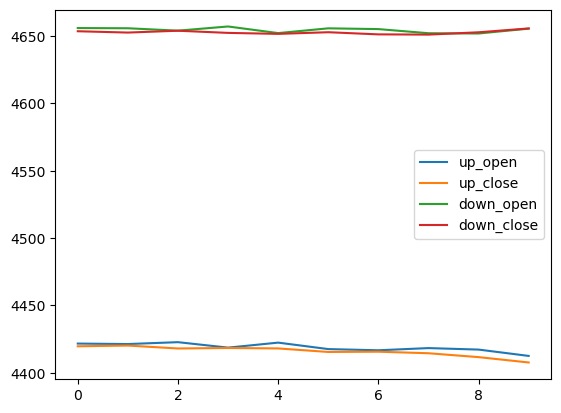

In [229]:
plt.plot(up_values["open"], label="up_open")
plt.plot(up_values["close"], label="up_close")
plt.plot(down_values["open"], label="down_open")
plt.plot(down_values["close"], label="down_close")
plt.legend()

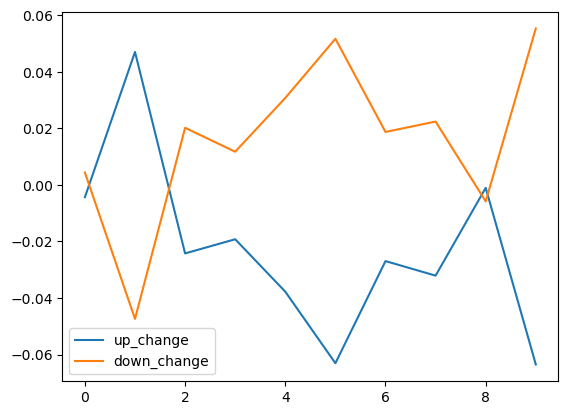

In [230]:
plt.plot(up_values["change"], label="up_change")
plt.plot(down_values["change"], label="down_change")
plt.legend()

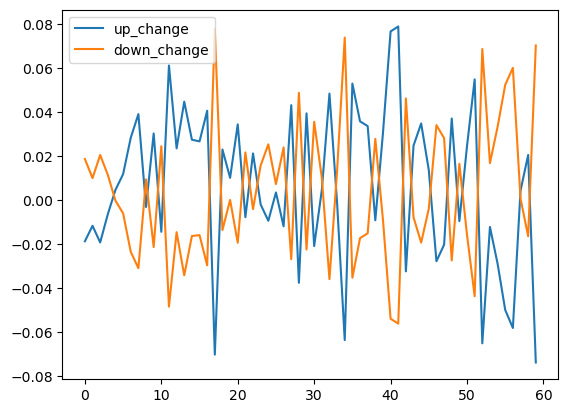

In [213]:
plt.plot(up_values["change"], label="up_change")
plt.plot(down_values["change"], label="down_change")
plt.legend()

In [242]:
window = 90

up_values, up_count = 0,0
down_values, down_count = 0,0

for df in [if0_df, ih0_df, ic0_df, sc0_df, lh0_df]:
    change = df.loc[1:,"close"].values - df.loc[:(df.shape[0]-2),"close"].values
    change = np.hstack([[0], change])

    df["label"] = (df["close"] - df["open"]).apply(lambda x:1 if x>0 else 0)
    df["change"] = (change / df.loc[:,"close"].values) * 100
    
    for i in range(window, df.shape[0]-window):
        if df.loc[i+window,"label"] == 1:
            up_values += df.drop(["label","datetime"],axis=1).iloc[i:window+i,:].reset_index(drop=True)
            up_count += 1
        else:
            down_values += df.drop(["label","datetime"],axis=1).iloc[i:window+i,:].reset_index(drop=True)
            down_count += 1
    break
        
up_values = up_values / up_count
down_values = down_values / down_count

In [239]:
up_10 = df[df["label"] == 1].index[10:]
down_10 = df[df["label"] == 0].index[:10]

In [241]:
up_30 = df[df["label"] == 1].index[30:]
down_30 = df[df["label"] == 0].index[:30]

In [243]:
up_90 = df[df["label"] == 1].index[90:]
down_90 = df[df["label"] == 0].index[:90]

In [246]:
up_10, up_30, up_90.shape

(Int64Index([  19,   21,   23,   26,   29,   30,   31,   33,   34,   36,
             ...
             1318, 1319, 1320, 1322, 1324, 1327, 1332, 1334, 1340, 1344],
            dtype='int64', length=651),
 Int64Index([  60,   63,   64,   65,   72,   74,   75,   76,   77,   80,
             ...
             1318, 1319, 1320, 1322, 1324, 1327, 1332, 1334, 1340, 1344],
            dtype='int64', length=631),
 (571,))